# [2020-1 캡스톤 A 진행상황](https://www.dropbox.com/scl/fi/26ro6knx4mwjuqdnz1ri7/2020-1-A.papert?dl=0&rlkey=kud882g1ldzf010rkb8fq6ras)
작성일 : 2020-04-15

## 1. 푸리에 변환된 주요 피치값 학습(진행중)
목적 : FFT변환하여 연산된 피치값 학습 모델을 통해 라벨링

## 2.1 데이터 가공
### 2.1.1. 푸리에 변환(STFT) 및 피치생성

In [18]:
import librosa
import scipy.signal as signal
import numpy as np
import pandas as pd 

In [19]:
def data_load(id):
    #workplace의 wav 파일 폴더에 지하철 안내음성 토큰 단위 파일 불러오기
    audio_sample, sampling_rate = librosa.load("wav/"+str(id)+".wav", sr = None)
    
    #stft 처리
    #변수는 임의 상정(혹은 기본값)
    S = np.abs(librosa.stft(audio_sample, n_fft=1024, hop_length=512, win_length = 1024, window=signal.hann))
    pitches, magnitudes = librosa.piptrack(S=S, sr=sampling_rate)
    shape = np.shape(pitches)
    nb_pitch = shape[0]
    nb_time = shape[1]
    #피치 생성
    for i in range(0, nb_time):
        index = magnitudes[:,i].argmax()
        pitch = pitches[index,i]
    df_pitch = pd.DataFrame(pitches)
    
    #데이터 생성
    #col : 피쳐(피치값), row : time
    df_pitch = df_pitch.T
    df_pitch.to_csv("data/"+str(id)+".csv", index=False)
    
    #편의를 위해 추가한 코드...
    #col 크기 94로 통일
    df_tmp = pd.read_csv("data/"+str(id)+".csv")
    drop_col = [str(i) for i in range(94, nb_pitch)]
    df_tmp = df_tmp.drop(drop_col, axis=1)
    df_tmp.to_csv("data/"+str(id)+".csv")

In [20]:
#2호선 내선순환 43개역
for i in range(0,43):
    data_load(id=i)

### 2.1.2 라벨링

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(train_label)

train_label_onehot = enc.transform(train_label).toarray()
train_label_recovery = np.argmax(train_label_onehot, axis=1).reshape(-1,1)

### 2.1.3 데이터 로드

In [43]:
import os
import multiprocessing
from multiprocessing import Pool
from functools import partial
import numpy as np
import pandas as pd 
from data_loader_v2 import data_loader_v2

In [28]:
#데이터 경로 설정
train_folder = 'data/'
train_label_path = 'train_label.csv'
#데이터 불러오기
train_list = os.listdir(train_folder)
train_label = pd.read_csv(train_label_path, index_col=0)

In [44]:
def data_loader_all(func, files, folder='', train_label=None, event_time=0, nrows=1000):   
    #변수 값 고정하여 파생 함수
    func_fixed = partial(func, folder=folder, train_label=train_label, event_time=event_time, nrows=nrows)     
    
    #cpu에 작업 분할
    if __name__ == '__main__':
        pool = Pool(processes=multiprocessing.cpu_count()) 
        df_list = list(pool.imap(func_fixed, files)) 
        pool.close()
        pool.join()        
    
    #df생성
    combined_df = pd.concat(df_list)    
    return combined_df

In [46]:
train = data_loader_all(data_loader_v2, train_list, folder=train_folder, train_label=train_label, event_time=0, nrows=1000)

In [47]:
#데이터 프레임생성
X_train = train.drop(['label'], axis=1)
y_train = train['label']

In [48]:
#csv로 저장
X_train.to_csv("X_train.csv", index = False, header = False)
y_train.to_csv("y_train.csv", index = False, header = False)

In [61]:
train.to_csv("train.csv", index = False, header = False)

## 2.2 데이터 전처리
### 2.2.1 스케일링(정규화, 표준화)
### 2.2.2 차원축소(pca, lda)

In [59]:
#원본 데이터세트
#랜덤 포레스트 이용해 타깃 값이 디폴트 값을 3개 교차 검증 세트로 분류 예측
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rcf=RandomForestClassifier(n_estimators=300, random_state=156)
scores = cross_val_score(rcf, X_train, y_train, scoring='accuracy', cv=3)
print('CV3인 경우 개별 fold 세트별 정확도 : ', scores)
print('평균 정확도 : {0:.4f}'.format(np.mean(scores)))

CV3인 경우 개별 fold 세트별 정확도 :  [0.04501173 0.04207674 0.04036802]
평균 정확도 : 0.0425


In [60]:
#PCA차원축소
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#원본스케일링 - 스텐다드
scaler = StandardScaler()
df_scaled=scaler.fit_transform(X_train)
#컴포넌트 임의 6개 선정
pca=PCA(n_components=6)
df_pca = pca.fit_transform(df_scaled)
scores_pca = cross_val_score(rcf,df_pca, y_train, scoring='accuracy', cv=3)
print('CV3인 경우 PCA변환된 개별 fold 세트별 정확도 : ', scores_pca)
print('PCA 변환 데이터 세트 평균 정확도 : {0:.4f}'.format(np.mean(scores_pca)))

CV3인 경우 PCA변환된 개별 fold 세트별 정확도 :  [0.04152741 0.03886749 0.03815705]
PCA 변환 데이터 세트 평균 정확도 : 0.0395


In [64]:
from sklearn.preprocessing import RobustScaler
#원본스케일링 - 로버스트
scaler = RobustScaler()
df_scaled=scaler.fit_transform(X_train)
#컴포넌트 임의 6개 선정
pca=PCA(n_components=6)
df_pca = pca.fit_transform(df_scaled)
scores_pca = cross_val_score(rcf,df_pca, y_train, scoring='accuracy', cv=3)
print('CV3인 경우 PCA변환된 개별 fold 세트별 정확도 : ', scores_pca)
print('PCA 변환 데이터 세트 평균 정확도 : {0:.4f}'.format(np.mean(scores_pca)))

CV3인 경우 PCA변환된 개별 fold 세트별 정확도 :  [0.04294958 0.03950934 0.03580344]
PCA 변환 데이터 세트 평균 정확도 : 0.0394


In [65]:
from sklearn.preprocessing import MinMaxScaler
#원본스케일링 - 로버스트
scaler = MinMaxScaler()
df_scaled=scaler.fit_transform(X_train)
#컴포넌트 임의 6개 선정
pca=PCA(n_components=6)
df_pca = pca.fit_transform(df_scaled)
scores_pca = cross_val_score(rcf,df_pca, y_train, scoring='accuracy', cv=3)
print('CV3인 경우 PCA변환된 개별 fold 세트별 정확도 : ', scores_pca)
print('PCA 변환 데이터 세트 평균 정확도 : {0:.4f}'.format(np.mean(scores_pca)))

CV3인 경우 PCA변환된 개별 fold 세트별 정확도 :  [0.04088744 0.03687063 0.03780044]
PCA 변환 데이터 세트 평균 정확도 : 0.0385


## 2.3 데이터 EDA
### 2.3.1 피처값 간 상관관계 분석

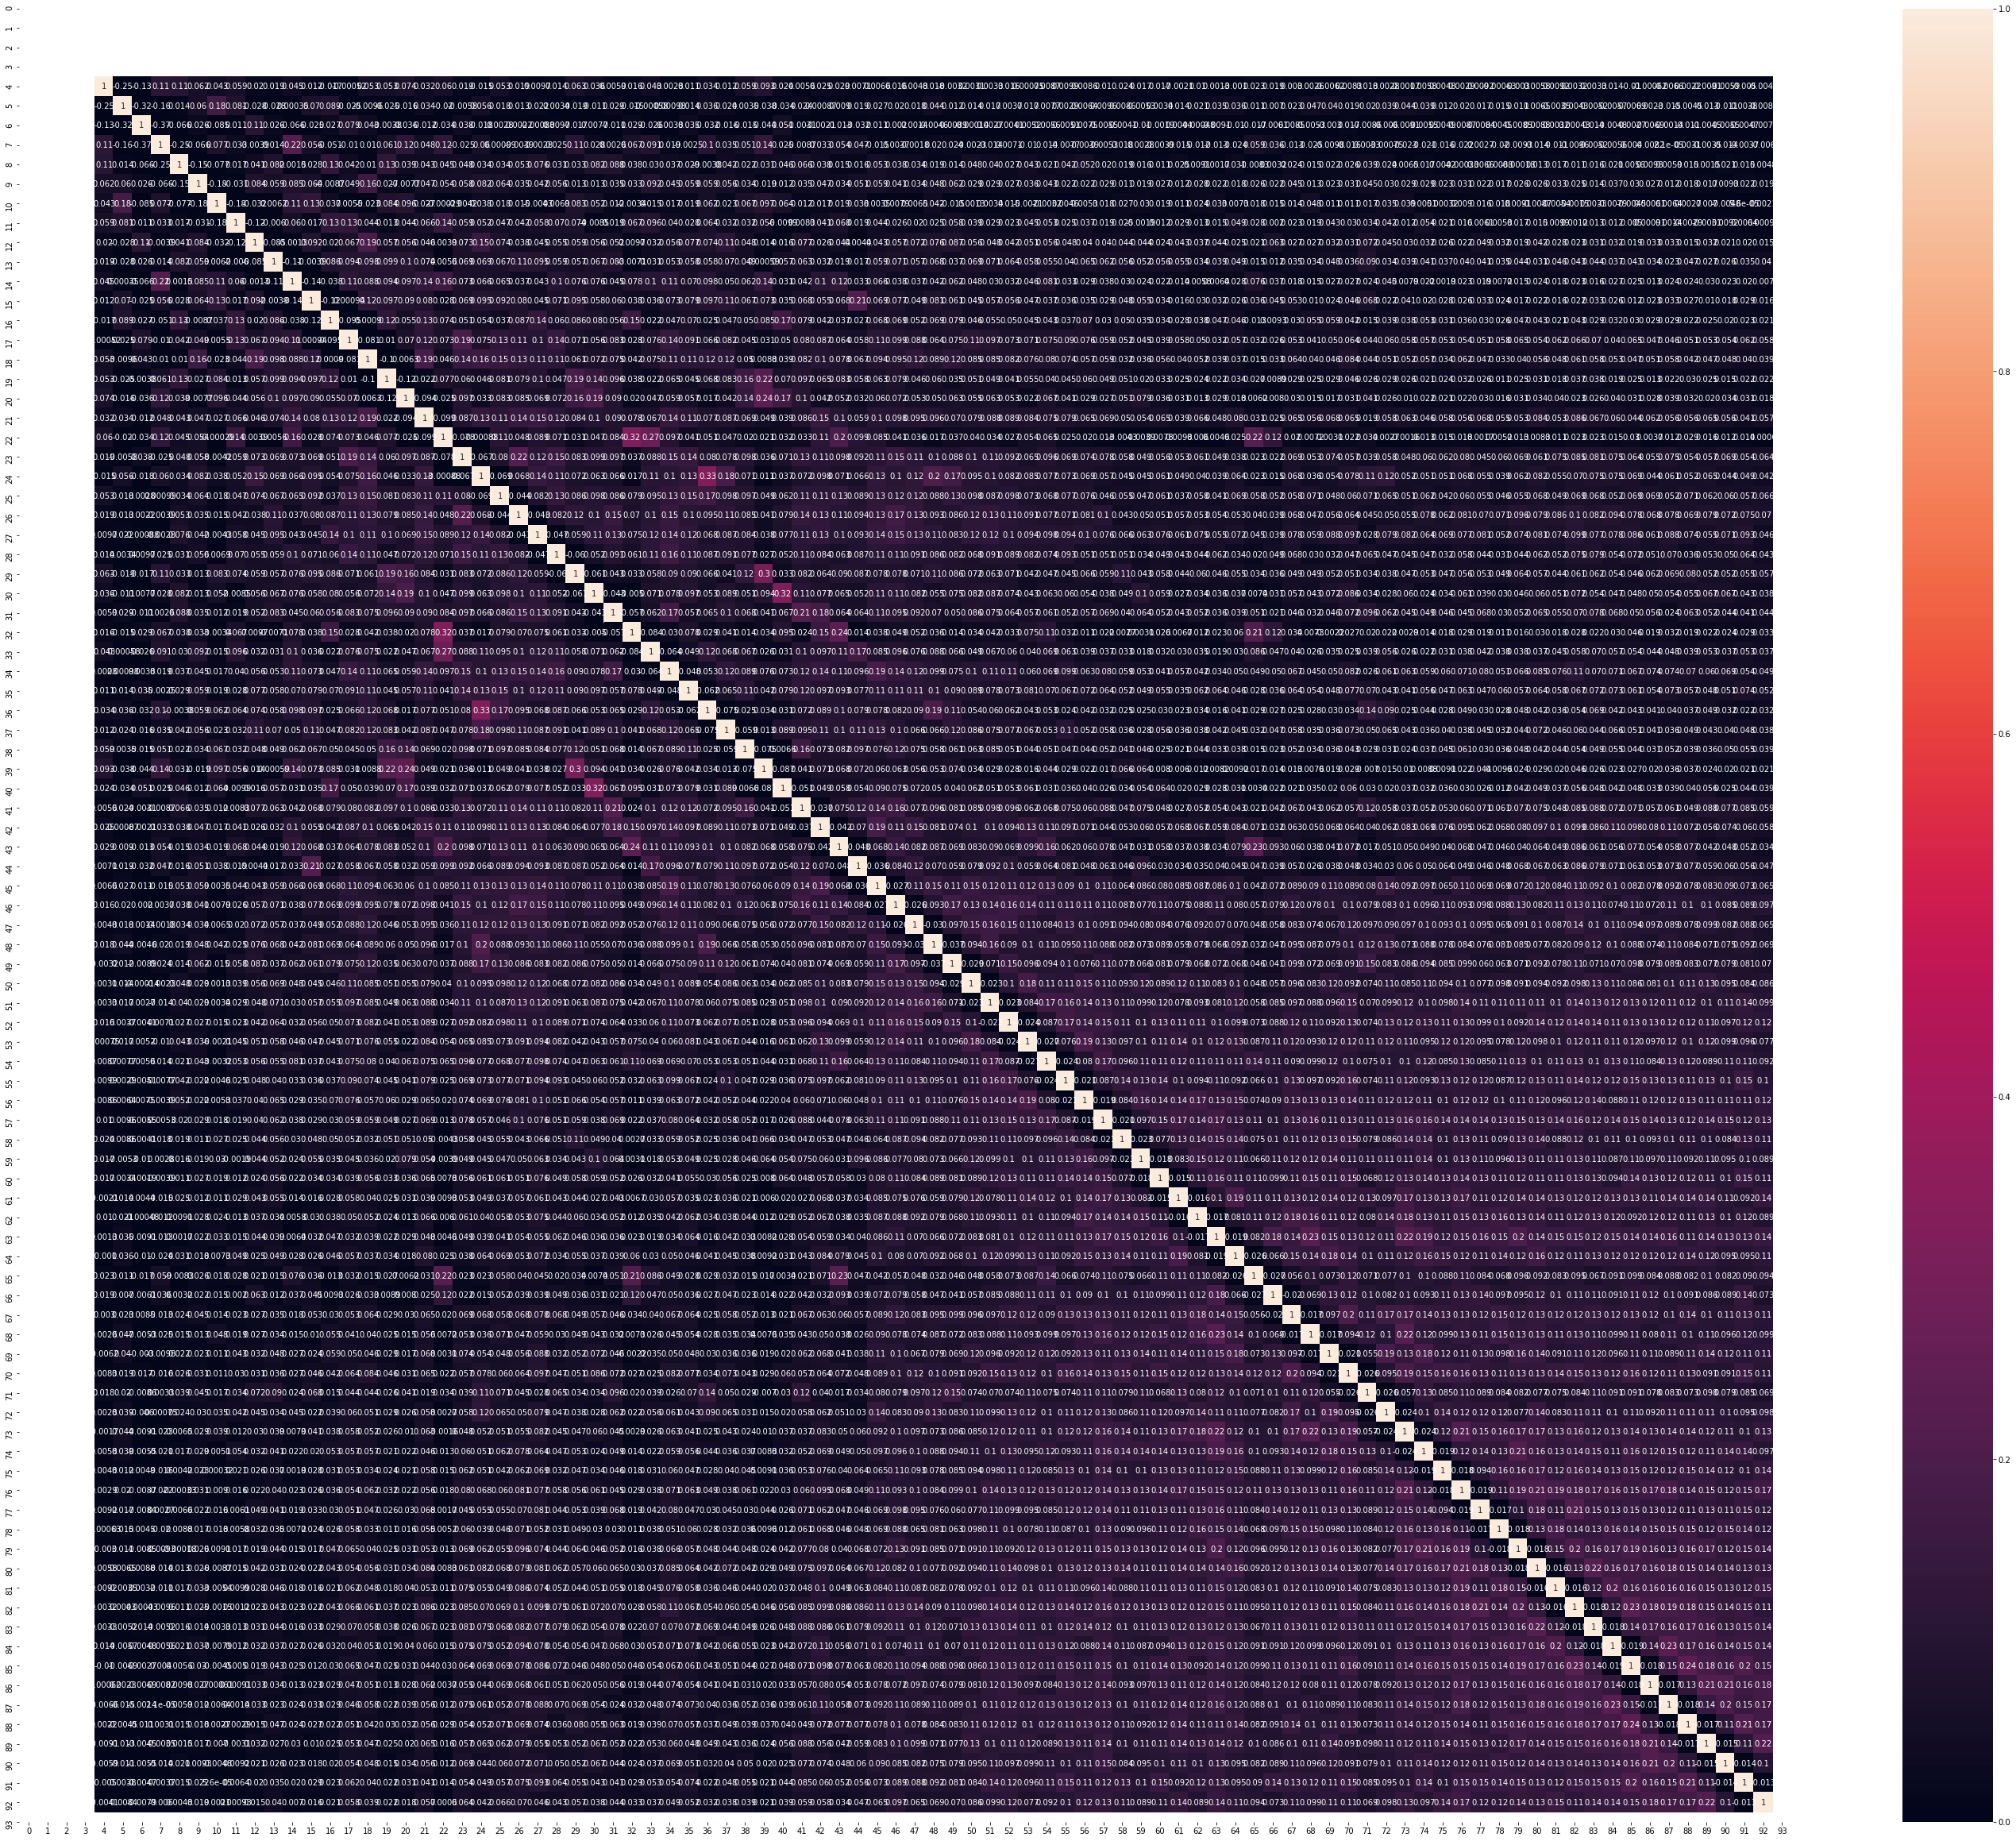

In [66]:
plt.figure(figsize=(50, 42))
sns.heatmap(X_train.corr(), vmin=0, vmax=1, annot=True)

## 2.4 모델링
### 2.4.1 모델 선정(lgbm)

In [68]:
import matplotlib
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import lightgbm as lgbm

In [69]:
X=X_train
y=y_train

### 2.4.2 하이퍼파라미터튜닝

In [75]:
#목적함수 생성
def lgbm_cv(learning_rate, n_estimators, num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
    model = lgbm.LGBMClassifier(learning_rate=learning_rate,
                                n_estimators=int(n_estimators),
                                num_leaves = int(num_leaves),
                                feature_fraction = feature_fraction,
                                bagging_fraction = bagging_fraction,
                                max_depth = int(round(max_depth)),
                                lambda_l1 = max(lambda_l1, 0),
                                lambda_l2 = max(lambda_l2, 0),
                                min_split_gain = min_split_gain,
                                min_child_weight = min_child_weight)
    RMSE = cross_val_score(model, X, y, scoring='accuracy', cv=5).mean()
    return -RMSE

In [76]:
# 입력값의 탐색 대상 구간
# 입력값의 탐색 대상 구간
pbounds = {'learning_rate' : (0.01, 0.3),
           'n_estimators' : (50, 1000),
           'num_leaves': (24, 45),
           'feature_fraction': (0.1, 0.9),
           'bagging_fraction': (0.8, 1),
           'max_depth': (5, 8.99),
           'lambda_l1': (0, 5),
           'lambda_l2': (0, 3),
           'min_split_gain': (0.001, 0.1),
           'min_child_weight': (5, 50)
          }

In [77]:
#객체 생성
lgbmBO = BayesianOptimization(f = lgbm_cv,pbounds = pbounds, verbose = 2, random_state = 1 )

In [ ]:
# 반복적으로 베이지안 최적화 수행
# acq='ei'사용
# xi=0.01 로 exploration의 강도를 조금 높임
lgbmBO.maximize(init_points=4, n_iter = 16, acq='ei', xi=0.01)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_sp... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -0.04522  |  0.8834   |  0.6763   |  0.000571 |  0.907    |  0.05256  |  5.368    |  13.38    |  0.03521  |  426.9    |  35.32    |


In [ ]:
lgbmBO.max # 찾은 파라미터 값 확인

In [ ]:
model_lgbm  = fit_lgbm.fit(X,y)

In [ ]:
import joblib
joblib.dump(model, 'model.pkl')

### 2.4.3 앙상블(보팅, 스태킹)

In [ ]:
pred = model.predict_proba(test)